# `numpy` Neural Networks: Mini-batches, Momentum & learning Rate Decay

We've got a multi-layer neural network that can learn to classify the "hard" data. However, training is a bit unstable. Let's implement some tricks of the trade to help improve the training process. Thanks to Eric Postma for suggesting this direction!

These training improvements require adjusting some functions that we've already defined. In this notebook we will copy/paste a new version of each function that is being adjusted so that we can compare to the old version. We'll comment important changes in the code.

First, all the boilerplate from the previous notebooks. Maybe it's getting time to use a `common.py`...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

The toy dataset

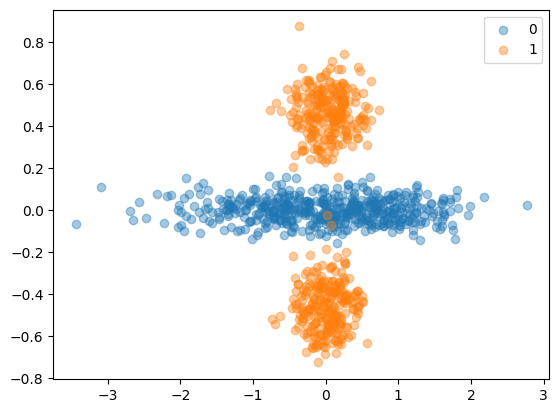

In [2]:
def rescale(X):
    return (X - X.mean(axis=0)) / (X.var(axis=0))

np.random.seed(1337)
n_samples = 1000
X0 = np.random.normal(loc=[0,0], scale=[2,0.5], size=(int(n_samples/2), 2))
X11 = np.random.normal(loc=[0,4], scale=[0.5,1], size=(int(n_samples/4), 2))
X12 = np.random.normal(loc=[0,-4], scale=[0.5,1], size=(int(n_samples/4), 2))
X1 = np.vstack([X11, X12])
X = np.vstack([X0, X1])

X = rescale(X)

y0 = np.zeros(shape=(int(n_samples/2), 1))
y1 = np.ones(shape=(int(n_samples/2), 1))
yhat = np.vstack([y0, y1])

# shuffle the data
inds = np.random.permutation(np.arange(n_samples))
X = X[inds]
yhat = yhat[inds]

X0 = X[(yhat==0).reshape(-1)]
X1 = X[(yhat==1).reshape(-1)]

plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

Activations & cost function

In [3]:
def relu(z):
    return np.where(z>0, z, 0)
    
def drelu_dz(z):
    return np.where(z>0, 1, 0)

def sig(z):
    return 1 / (1 + np.exp(-z))

def dsig_dz(z):
    return sig(z) * (1 - sig(z))

def J(y, yhat):
    eps = 1e-8
    return -(yhat*np.log(y+eps) + (1-yhat)*np.log(1-y+eps))

def dJ_dy(y, yhat):
    eps = 1e-8
    return (1-yhat)/(1-y+eps) - yhat/(y+eps)


Model initialization, forward & backward passes. Set the random seed so that we always initialize to the same values, so that we can compare different training strategies fairly.

In [4]:
def init_model(shape):
    np.random.seed(1234)
    w = {}
    b = {}
    for layer in range(1, len(shape)):  # no weights for the input layer
        w[layer] = np.random.normal(0, 0.5, size=(shape[layer-1], shape[layer]))  # dim: from_units, to_units
        b[layer] = np.random.normal(0, 0.5, size=(shape[layer], 1))  # dim: to_units, 1
    return w,b

def forwardn(x0, w, b):
    n_layers = len(w)
    x_prev = x0
    for l in range(1, n_layers):
        x_l = relu(np.dot(x_prev, w[l]) + b[l].T)  # output of a hidden layer
        x_prev = x_l
    return sig(np.dot(x_prev, w[n_layers]) + b[n_layers].T)  # output of output layer

def backwardn(x0, w, b, y, yhat, alpha):
    n_layers = len(w)
    z = {}
    x = {0:x0}
    
    # x and z values for calculating derivatives
    for l in range(1, n_layers+1):
        z[l] = np.dot(x[l-1], w[l]) + b[l].T
        x[l] = relu(z[l])
        
    delta = {}
    
    # deltas and updates
    for l in range(n_layers, 0, -1):  # start with last layer and move backward
        if l == n_layers:  # base case
            delta[l] = dJ_dy(y, yhat)*dsig_dz(z[n_layers])
        else:  # recursive case
            delta[l] = np.dot(w[l+1], delta[l+1]) * drelu_dz(z[l]).T

        # update weights and biases
        w[l] -= alpha * np.multiply(delta[l], x[l-1]).T
        b[l] -= alpha * delta[l]
    
    return w, b

Training function

In [5]:
def trainn(X, yhat, shape, alpha, n_epoch):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape)

    for epoch in range(n_epoch):
        for i in range(n_samples):
            x0 = X[i,:]; yh = yhat[i]
            y = forwardn(x0, w, b)  # prediction for one sample
            w, b = backwardn(x0, w, b, y, yh, alpha)  # take step
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forwardn(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        print('\rTraining accuracy after epoch {}: {:.4%}'.format(epoch, accuracy), end='')
            
    print()    
    return w, b, costs

Train the MLP from the previous notebook

Training accuracy after epoch 149: 99.4000%
CPU times: user 13.8 s, sys: 404 ms, total: 14.2 s
Wall time: 13.6 s


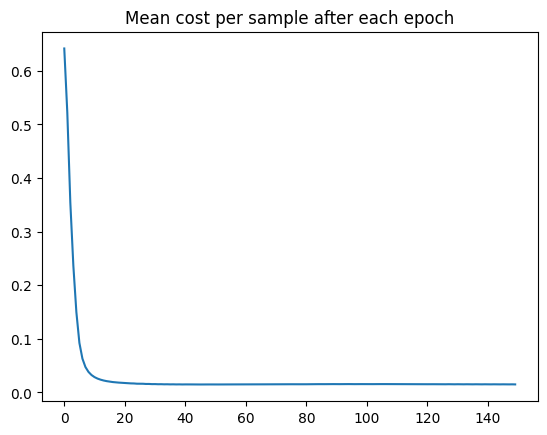

In [6]:
shape = (2,3,4,1)
alpha = 0.01
n_epoch = 150
%time w, b, costs = trainn(X, yhat, shape, alpha, n_epoch)
plt.plot(costs); plt.title('Mean cost per sample after each epoch');

/tmp/ipykernel_649208/792060028.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun_map[m,n] = forwardn([i,-j], w, b)


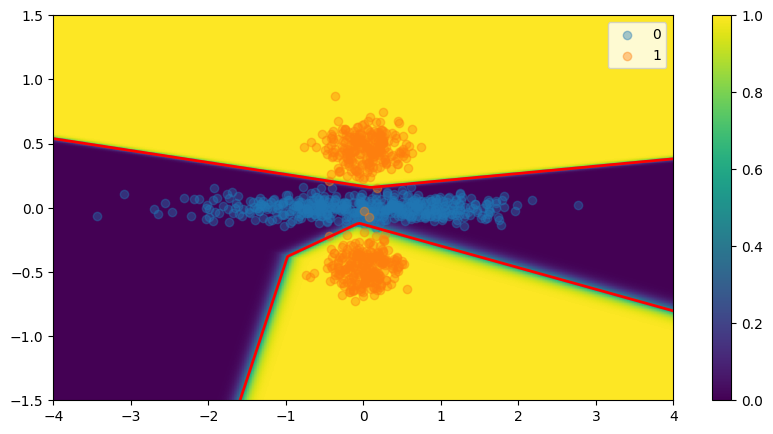

In [7]:
x1 = np.linspace(-4,4,250)
x2 = np.linspace(-1.5,1.5,250)
fun_map = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map[m,n] = forwardn([i,-j], w, b)

X0 = X[(yhat==0).reshape(-1)]
X1 = X[(yhat==1).reshape(-1)]

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.contour(x1, -x2, fun_map, levels=[0.5], colors=['r'], linewidths=2)
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

# Mini-Batches

So far we have been doing stochastic gradient descent (SGD), which takes one step per sample. However, this can be a bit chaotic: we make a lot of updates using not a lot of data. We can start to smooth our process out by using so-called mini-batches (small groups of data points), and taking a step in the average direction dictated by doing backprop on each of those points.

We first adjust our backward pass to accept multiple samples, and update `w` and `b` with the mean steps.

Our new backprop functions, `backward_mini` will now accept a matrix `X0` as input, calculate the updates for each row, and average over those before making one update to `w` and `b`.

Let's update our notation and call the update rule

$$ w^\ell\ \rightarrow\ w^\ell - \alpha\,dw^\ell $$

(and similar for $b$). This will allow us to talk more generally about changes to the update rule. 

Consider mini-batches of $m_{batch}$ samples, and let's consider weights between layers with $n^{\ell-1}$ and $n^\ell$ units. In the SQG case, $\delta^\ell$ had a shape of $(n^\ell,\, 1)$ (the same shape as $b^\ell$). Now we stack our calculated $\delta$s so that we get a matrix of shape $(n^\ell,\, m_{batch})$, one column per sample. The block of samples itself has shape $(m_{batch},\, n^{\ell-1})$. Recalling that $dw^\ell = \delta^\ell x^{\ell-1}$, we see the the dimension of size $m_{batch}$ is summed over (effectively summing over all the samples). For that reason we adjust the update rule to

$$ dw^\ell = \delta^\ell x^{\ell-1} / m_{batch}  $$

so that we get an average instead of a sum. The approach for $db$ is simpler: we simply take a mean over the axis corresponding to the features. It's important here to take the mean using `delta[l].mean(axis=1, keepdims=True)`, where `keepdims=True` prevents numpy from making annoying 0-dimensional vectors after the mean.

Because the steps we take are averaged over several samples, they are more stable than in stochastic gradient descent, so we can afford a larger learning rate and still expect to converge onto a solution.

In [8]:
def backward_mini(X0, w, b, y, yhat, alpha):
    n_layers = len(w)
    batch_size = len(yhat)
    z = {}
    x = {0:X0}
    delta = {}

    # x and z values for calculating derivatives
    for l in range(1, n_layers+1):
        z[l] = np.matmul(x[l-1], w[l]) + b[l].T  # matmul instead of dot
        x[l] = relu(z[l])
            
    # deltas and updates
    for l in range(n_layers, 0, -1):  # start with last layer and move backward
        if l == n_layers:  # base case
            # delta is a column, so make the deltas from the samples go along axis 1 by transposing
            delta[l] = (dJ_dy(y, yhat) * dsig_dz(z[n_layers])).T
        else:  # recursive case
            delta[l] =  np.matmul(w[l+1], delta[l+1]) * drelu_dz(z[l]).T
        
        dw = np.matmul(delta[l], x[l-1]).T / batch_size  # mean over samples
        db = delta[l].mean(axis=1, keepdims=True)  # mean over samples
        
        # update weights and biases
        w[l] -= alpha * dw
        b[l] -= alpha * db
    
    return w, b

The training script requires minimal adjustment. We add an extra parameter `batch_size` and use it to loop through the training set taking steps of that size, passing these blocks to the backward function.

In [9]:
def train_mini(X, yhat, shape, alpha, n_epoch, batch_size):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape)

    for epoch in range(n_epoch):
        for i in range(0, n_samples, batch_size):
            X_batch = X[i:i+batch_size,:]
            yh = yhat[i:i+batch_size]
            
            y = forwardn(X_batch, w, b)  # prediction for mini-batch
            w, b = backward_mini(X_batch, w, b, y, yh, alpha)  # take step
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forwardn(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        print('\rTraining accuracy after epoch {}: {:.4%}'.format(epoch, accuracy), end='')
            
    print()    
    return w, b, costs

We will use a batch-size of 32, and increase the learning rate $\alpha$ from 0.01 to 0.1. Note that at $\alpha=0.1$, the previous SGD training run doesn't even converge!

Training accuracy after epoch 1999: 99.7000%
CPU times: user 10.3 s, sys: 24.6 ms, total: 10.3 s
Wall time: 10.3 s


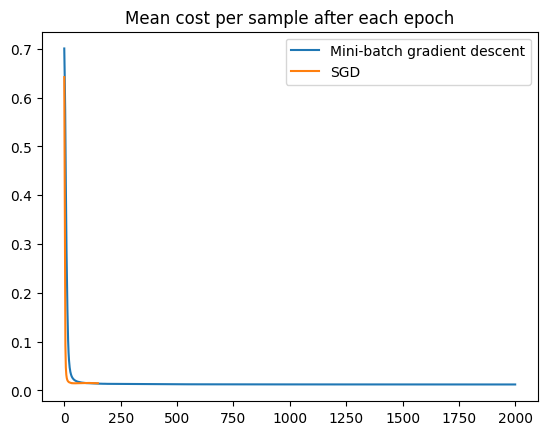

In [10]:
batch_size = 32
shape = (2,3,4,1)
alpha = 0.1
n_epoch = 2000
%time w_mini, b_mini, costs_mini = train_mini(X, yhat, shape, alpha, n_epoch, batch_size)
plt.plot(costs_mini, label='Mini-batch gradient descent')
plt.plot(costs, label='SGD')
plt.legend()
plt.title('Mean cost per sample after each epoch');

/tmp/ipykernel_649208/3510520332.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun_map_mini[m,n] = forwardn([i,-j], w_mini, b_mini)


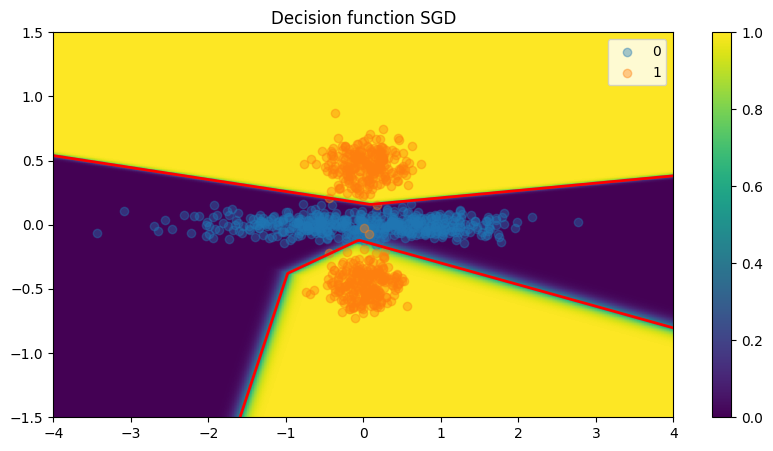

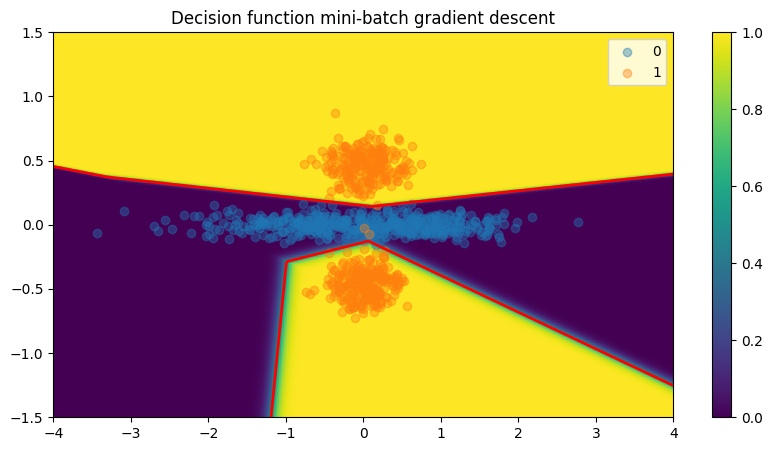

In [11]:
x1 = np.linspace(-4,4,250)
x2 = np.linspace(-1.5,1.5,250)
fun_map_mini = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map_mini[m,n] = forwardn([i,-j], w_mini, b_mini)

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.contour(x1, -x2, fun_map, levels=[0.5], colors=['r'], linewidths=2)
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend()
plt.title('Decision function SGD')
plt.show;

plt.figure(figsize=(10,5))
plt.imshow(fun_map_mini, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.contour(x1, -x2, fun_map_mini, levels=[0.5], colors=['r'], linewidths=2)
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.title('Decision function mini-batch gradient descent')
plt.legend();

We see that we can go through *many* more epochs in the same amount of wall-clock time, as we take far fewer update steps per epoch. However, the convergence happens in around the same number of epochs, so in the same amount of time we can make much more progress. Comparing the plots, we see that the gradients are a bit sharper, i.e. the model is much more sure of itself, and we also have improved our accuracy.

# Momentum

The idea behind momentum is to take update steps that are an average over the current step calculated from backprop, and the previous step. The motivation is that small oscillations should cancel out, while actual progress should not be affected by the averaging.

In practice this is done by taking an exponentially weighted moving average of the $dw$ and $db$ obtained by backprop, and updating using the average step. The weighting is parameterized by the momentum parameter $\beta$. At step $t$, the updates are:

$$\begin{align*}
dw_{mom}[t] = \beta\, dw_{mom}[t-1] + (1-\beta)\, dw_{backprop}[t]
\end{align*}$$

So the $dw$ calculated from backprop $\tau$ steps ago appears as a term in the weighted sum with a weight $\beta^\tau$. A typical value for $\beta$ is around 0.9, which corresponds to having the last approximately 10 steps significantly contributing to $dw$.

In our implementation we now need to keep track of what the previous $dw$ and $db$ were for each layer, and update these values using the newly calculated ones from backprop. We do this by keeping them in a dictionary.

In [12]:
def backward_mom(X0, w, b, y, yhat, dw, db, alpha, beta):
    n_layers = len(w)
    batch_size = len(yhat)
    z = {}
    x = {0:X0}
    delta = {}

    # x and z values for calculating derivatives
    for l in range(1, n_layers+1):
        z[l] = np.matmul(x[l-1], w[l]) + b[l].T
        x[l] = relu(z[l])
            
    # deltas and updates
    for l in range(n_layers, 0, -1):  # start with last layer and move backward
        if l == n_layers:  # base case
            
            delta[l] = (dJ_dy(y, yhat) * dsig_dz(z[n_layers])).T
        else:  # recursive case
            delta[l] =  np.matmul(w[l+1], delta[l+1]) * drelu_dz(z[l]).T
            
        # Updates from backprop
        dw_new = np.matmul(delta[l], x[l-1]).T / batch_size
        db_new = delta[l].mean(axis=1, keepdims=True)
        
        # Exp. weighted average
        dw[l] = beta*dw[l] + (1-beta)*dw_new
        db[l] = beta*db[l] + (1-beta)*db_new
        
        # update weights and biases
        w[l] -= alpha * dw[l]
        b[l] -= alpha * db[l]
    
    return w, b, dw, db

def train_mom(X, yhat, shape, alpha, n_epoch, batch_size, beta):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape)

    # initialize dw and db to zero
    dw = {l:np.zeros_like(wl) for l,wl in w.items()}
    db = {l:np.zeros_like(bl) for l,bl in b.items()}
    
    for epoch in range(n_epoch):
        for i in range(0, n_samples, batch_size):
            X_batch = X[i:i+batch_size,:]
            yh = yhat[i:i+batch_size]
            
            y = forwardn(X_batch, w, b)  # prediction for mini-batch
            w, b, dw, db = backward_mom(X_batch, w, b, y, yh, dw, db, alpha, beta)  # take step
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forwardn(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        print('\rTraining accuracy after epoch {}: {:.4%}'.format(epoch, accuracy), end='')
            
    print()    
    return w, b, costs

Training accuracy after epoch 149: 99.4000%
CPU times: user 24.6 s, sys: 229 ms, total: 24.8 s
Wall time: 24.6 s


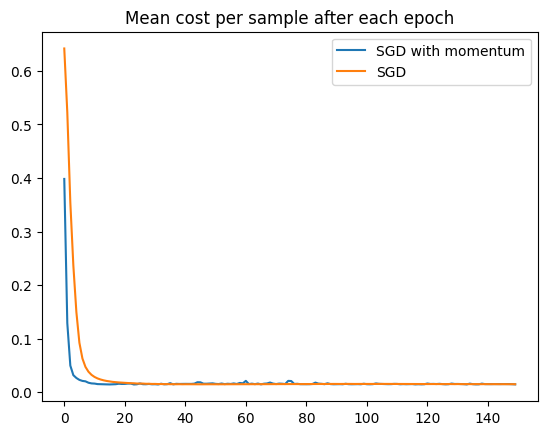

In [13]:
batch_size = 1
shape = (2,3,4,1)
alpha = 0.03
beta = 0.9
n_epoch = 150
%time w_mom, b_mom, costs_mom = train_mom(X, yhat, shape, alpha, n_epoch, batch_size, beta)
plt.plot(costs_mom, label='SGD with momentum')
plt.plot(costs, label='SGD')
plt.legend()
plt.title('Mean cost per sample after each epoch');

/tmp/ipykernel_649208/1908160537.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun_map_mom[m,n] = forwardn([i,-j], w_mom, b_mom)


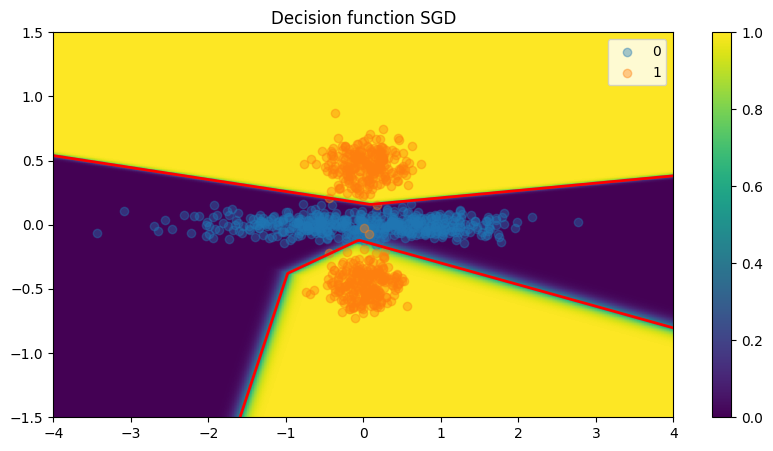

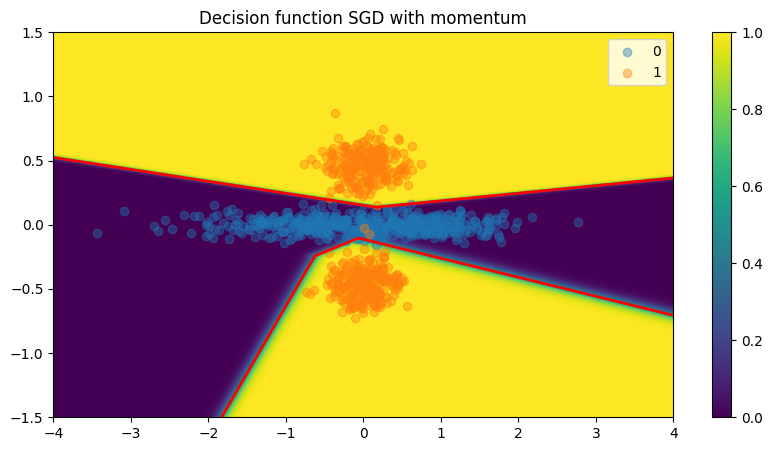

In [14]:
x1 = np.linspace(-4,4,250)
x2 = np.linspace(-1.5,1.5,250)
fun_map_mom = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map_mom[m,n] = forwardn([i,-j], w_mom, b_mom)

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.contour(x1, -x2, fun_map, levels=[0.5], colors=['r'], linewidths=2)
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend()
plt.title('Decision function SGD')
plt.show();

plt.figure(figsize=(10,5))
plt.imshow(fun_map_mom, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.contour(x1, -x2, fun_map_mom, levels=[0.5], colors=['r'], linewidths=2)
plt.title('Decision function SGD with momentum')
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

Again the more stable steps afforded us a higher learning rate, but we see that the effect was less pronounced than with mini-batching for this problem. Furthermore, although we made a lot of initial progress, we see that the training was a little unstable towards the end. This is an indication that the learning rate was actually slightly too large at that point. To help deal with this problem, we turn to learning rate decay.

# Learning Rate Decay

Learning rate decay involves gradually decreasing the learning rate $\alpha$ as the epochs go by. This allows for starting with a higher learning rate, to make big gains at the start of training, and then as we approach the minimum to slow down learning and start making more fine-grained adjustments to get as close as possible to the true minimum.

One approach is to define a number of steps and make the steps after a set number of epochs. We will take a smoother approach, and have the learning rate decay exponentially. This process is governed by another parameter, the decay rate $\gamma$. After each epoch we multiply the decay rate by $1-\gamma$:

$$ \alpha \rightarrow (1-\gamma)\, \alpha $$

Then after $n$ epochs, $\alpha$'s value is $(1-\gamma)^n$ of its original value. We have been training with $\alpha=0.01$ and 150 epochs.

To demonstrate, let's choose our $\gamma$ and initial $\alpha$ so that our decaying $\alpha$ will cross our constant alpha about halfway through training. It's a bit hard to see on a linear scale, but a log scale makes it clear what's going on:

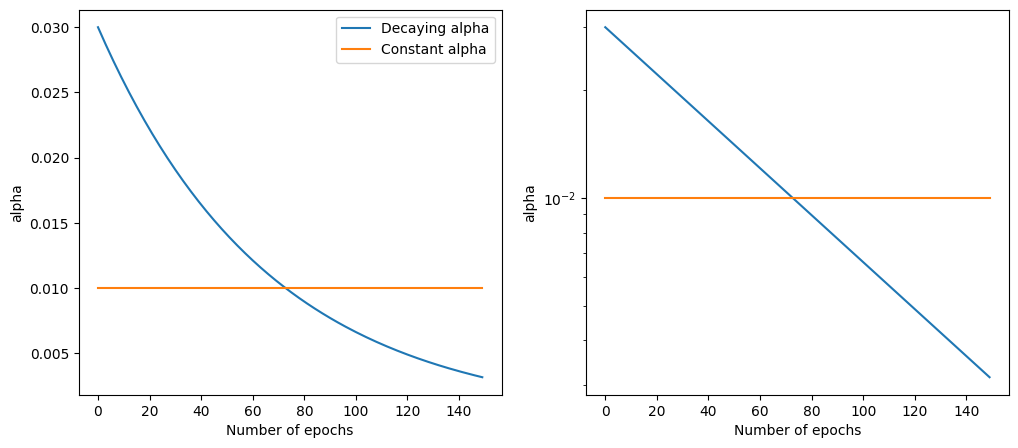

In [15]:
epochs = np.arange(0,150)
gamma = 0.015
alpha = 0.03
plt.figure(figsize=(12,5))
plt.subplot(1,2,1, )
plt.plot(alpha*(1-gamma)**epochs, label='Decaying alpha')
plt.plot(0.01*np.ones_like(epochs), label='Constant alpha')
plt.ylabel('alpha'); plt.xlabel('Number of epochs');
plt.legend();

plt.subplot(1,2,2)
plt.plot(alpha*(1-gamma)**epochs, label='Decaying alpha')
plt.plot(0.01*np.ones_like(epochs), label='Constant alpha')
plt.ylabel('alpha'); plt.xlabel('Number of epochs')
plt.yscale('log');

To implement decay, we only need to tweak our training script a little, as the backpropagation is unaffected. Before we being looping through the epochs, we initialize the variable learning rate, and after each epoch we multiply this value by `(1-gamma)`. Let's test it out with our values from above!

In [16]:
def train_dec(X, yhat, shape, alpha, n_epoch, batch_size, beta, gamma):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape)

    # initialize dw and db to zero
    dw = {l:np.zeros_like(wl) for l,wl in w.items()}
    db = {l:np.zeros_like(bl) for l,bl in b.items()}
    
    alph = alpha
    
    for epoch in range(n_epoch):
        for i in range(0, n_samples, batch_size):
            X_batch = X[i:i+batch_size,:]
            yh = yhat[i:i+batch_size]
            
            y = forwardn(X_batch, w, b)  # prediction for mini-batch
            w, b, dw, db = backward_mom(X_batch, w, b, y, yh, dw, db, alph, beta)  # take step
        
        # Decay the learning rate
        alph *= (1 - gamma)
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forwardn(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        print('\rTraining accuracy after epoch {}: {:.4%}'.format(epoch, accuracy), end='')
            
    print()    
    return w, b, costs

Training accuracy after epoch 149: 99.8000%
CPU times: user 24.8 s, sys: 163 ms, total: 24.9 s
Wall time: 24.7 s


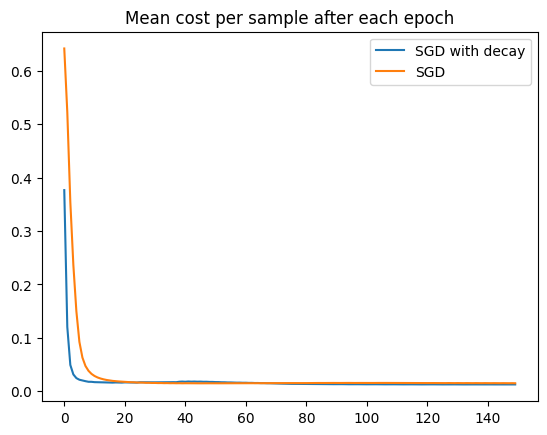

In [17]:
batch_size = 1
shape = (2,3,4,1)
gamma = 0.015
alpha = 0.03
beta = 0
n_epoch = 150
%time w_dec, b_dec, costs_dec = train_dec(X, yhat, shape, alpha, n_epoch, batch_size, beta, gamma)
plt.plot(costs_dec, label='SGD with decay')
plt.plot(costs, label='SGD')
plt.legend()
plt.title('Mean cost per sample after each epoch');

/tmp/ipykernel_649208/1020287456.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun_map_dec[m,n] = forwardn([i,-j], w_dec, b_dec)


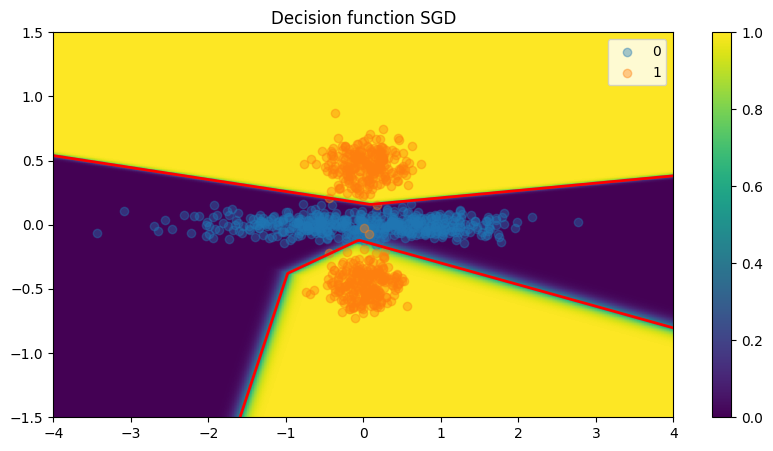

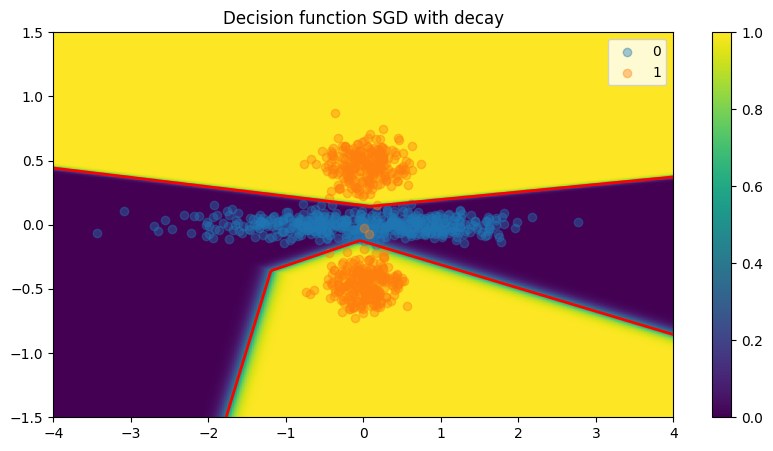

In [18]:
x1 = np.linspace(-4,4,250)
x2 = np.linspace(-1.5,1.5,250)
fun_map_dec = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map_dec[m,n] = forwardn([i,-j], w_dec, b_dec)

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.contour(x1, -x2, fun_map, levels=[0.5], colors=['r'], linewidths=2)
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend()
plt.title('Decision function SGD')
plt.show();

plt.figure(figsize=(10,5))
plt.imshow(fun_map_dec, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.contour(x1, -x2, fun_map_dec, levels=[0.5], colors=['r'], linewidths=2)
plt.title('Decision function SGD with decay')
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

We see again that we converged more quickly, but this time without the wobbles brought about by jumping over the minimum with a large step size towards the end of training. We also got a record high accuracy so far!

Of course, training set accuracy isn't everything, we have to be sure that we aren't overfitting. For this, we examine some regularization techniques in the next notebook.